# RISC-V Test Generation and Analysis

This notebook generates presentation-ready figures using the project modules in `src/`:
- Generation speed vs number of tests
- Distribution of instructions by type (R, I, S, B, U, J)
- Register usage distribution in generated tests (rd, rs1, rs2)

Figures are saved in the `figures/` directory.


In [15]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.3 MB 12.2 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.3 MB 11.7 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.3 MB 11.8 MB/s eta 0:00:01
   ---------------------------------- ----- 9.7/11.3 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.3 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 10.3 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import sys
import time
import json
from pathlib import Path
from collections import Counter, defaultdict
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(style="darkgrid")
# Ensure src is importable
project_root = '../'
src_path = './src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from test_generator import RiscVTestGenerator
from parser.instruction_parser import RiscVInstructionParser
from validate_riscv_code import RiscVValidator

# Output dir for figures
FIG_DIR = './figures'
print(f"Figures will be saved to: {FIG_DIR}")


Figures will be saved to: ./figures


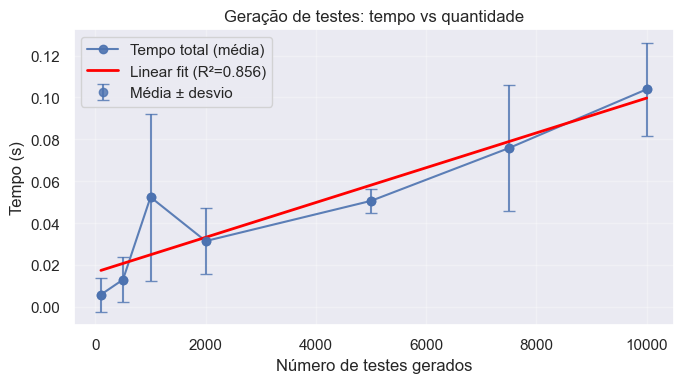

In [22]:
# Benchmark: generation speed vs number of tests

generator = RiscVTestGenerator()

sizes = [100, 500, 1000, 2000, 5000, 7500, 10000]
repeats = 5

times = []       # mean time per size
times_std = []   # standard deviation per size

# Pick a representative subset of instructions
instructions = generator.get_available_instructions()
if len(instructions) == 0:
    raise RuntimeError("No instructions available; ensure opcodes JSON is present.")

sample_instr = instructions[:min(20, len(instructions))]

for n in sizes:
    run_times = []
    for _ in range(repeats):
        start = time.perf_counter()
        # Generate a mix across sample instructions
        per_instr = max(1, n // len(sample_instr))
        total_cases = []
        for instr in sample_instr:
            total_cases.extend(generator.generate_random_test_case(instr, per_instr))
        # Adjust if we fell short/exceeded by a few due to integer division
        if len(total_cases) < n:
            total_cases.extend(generator.generate_random_test_case(sample_instr[0], n - len(total_cases)))
        elif len(total_cases) > n:
            total_cases = total_cases[:n]
        elapsed = time.perf_counter() - start
        run_times.append(elapsed)
    times.append(float(np.mean(run_times)))
    times_std.append(float(np.std(run_times, ddof=1)) if len(run_times) > 1 else 0.0)

# Compute normalized times (per test sample)
times_normalized = [t / n for t, n in zip(times, sizes)]

plt.figure(figsize=(7,4))
# Error bars
plt.errorbar(sizes, times, yerr=times_std, fmt='o', capsize=4, color='C0', ecolor='C0', alpha=0.8, label='Média ± desvio')
# Blue line (mean)
plt.plot(sizes, times, color='C0', linestyle='-', marker='o', alpha=0.9, label='Tempo total (média)')

# Linear fit and R^2 (using mean times)
x = np.array(sizes, dtype=float)
y = np.array(times, dtype=float)
if len(x) >= 2 and np.all(np.isfinite(y)):
    coeffs = np.polyfit(x, y, 1)
    y_fit = np.polyval(coeffs, x)
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1.0 - (ss_res / ss_tot if ss_tot != 0 else 0.0)
    plt.plot(sizes, y_fit, color='red', linewidth=2, label=f'Linear fit (R²={r2:.3f})')

plt.title('Geração de testes: tempo vs quantidade')
plt.xlabel('Número de testes gerados')
plt.ylabel('Tempo (s)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/gen_speed_vs_tests.png', dpi=200)
plt.show()


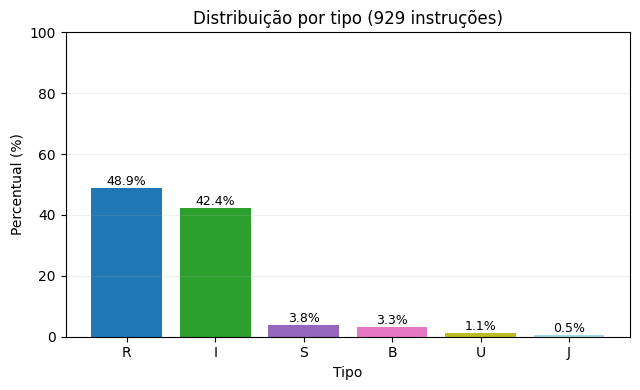

In [9]:
# Distribution of instructions by type (R, I, S, B, U, J)

# Read 'format' directly from opcode JSON (extension -> operations)
opcodes_paths = [
    './src/data/opcodes/all_opcodes.json',
]

opcodes_file = None
for p in opcodes_paths:
    opcodes_file = p
    break

if opcodes_file is None:
    raise FileNotFoundError('Could not find all_opcodes.json in expected paths.')

with open(opcodes_file, 'r', encoding='utf-8') as f:
    all_ops = json.load(f)

inst_type_counter = Counter()
for ext_name, ops in all_ops.items():
    for opname, meta in ops.items():
        fmt = meta.get('format')
        # Normalize to one of R/I/S/B/U/J/Unknown
        if isinstance(fmt, str):
            fmt_norm = fmt.upper()
            if fmt_norm not in {'R', 'I', 'S', 'B', 'U', 'J'}:
                fmt_norm = 'Unknown'
        else:
            fmt_norm = 'Unknown'
        inst_type_counter[fmt_norm] += 1

labels = ['R', 'I', 'S', 'B', 'U', 'J']
counts = [inst_type_counter.get(k, 0) for k in labels]
labels_alt = ['R', 'I', 'S', 'B', 'U', 'J', 'Unknown']
counts_alt = [inst_type_counter.get(k, 0) for k in labels_alt]
total_alt = sum(counts_alt)
total = sum(counts)
percents = [(c / total * 100.0) if total > 0 else 0.0 for c in counts]

plt.figure(figsize=(6.5,4))
colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))
plt.bar(labels, percents, color=colors)
plt.title(f'Distribuição por tipo ({total_alt} instruções)')
plt.xlabel('Tipo')
plt.ylabel('Percentual (%)')
for i, p in enumerate(percents):
    plt.text(i, p, f"{p:.1f}%", ha='center', va='bottom', fontsize=9)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.savefig('figures/instruction_type_distribution.png', dpi=200)
plt.show()


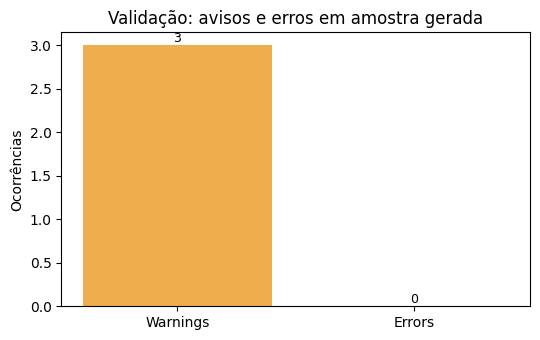

In [12]:
# Validator warnings/errors on generated sample

validator = RiscVValidator(enable_compile=False)

sample_size = 500
per_instr = 5

# Reuse generator and a subset of instructions
instructions = generator.get_available_instructions()
sample_instr = instructions[:min(30, len(instructions))]

warnings_counter = Counter()
errors_counter = Counter()

cases = []
for instr in sample_instr:
    cases.extend(generator.generate_random_test_case(instr, per_instr))

# Validate each generated assembly line
for i, case in enumerate(cases[:sample_size]):
    asm = case.get('assembly', '')
    res = validator.validate_assembly_line(asm, i+1)
    for w in res['warnings']:
        warnings_counter['warnings'] += 1
    for e in res['errors']:
        errors_counter['errors'] += 1

# Build a simple bar chart (counts)
labels = ['Warnings', 'Errors']
counts = [warnings_counter.get('warnings', 0), errors_counter.get('errors', 0)]

plt.figure(figsize=(5.5,3.5))
plt.bar(labels, counts, color=['#f0ad4e', '#d9534f'])
plt.title('Validação: avisos e erros em amostra gerada')
plt.ylabel('Ocorrências')
for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig('figures/validator_warnings_errors.png', dpi=200)
plt.show()
